In [175]:
#Installing imblearn

#!pip install imbalanced-learn
#!pip install ydata-profiling
#!pip install researchpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib
import seaborn as sns
import sklearn

#Libraries for penalised regressions
from numpy import arange
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.model_selection import RepeatedKFold,  cross_val_score
from itertools import product

#Pour le test ESD
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy.stats import chi2_contingency

#Descriptive analysis
from ydata_profiling import ProfileReport

#Up_Sampling
from imblearn.over_sampling import RandomOverSampler

#Over_Sampling
from imblearn.over_sampling import SMOTE

#Réequilibrage de nos données
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

#Régression logstique
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

#XGBOOST
import xgboost as xgb

#Outliers removal/correction
from scipy.stats.mstats import winsorize

#Test de students pour la validité d'une pair (quali/quanti)
from scipy.stats import ttest_ind

#Analyse de deux variables qualit
import researchpy as rp

#Pour la selection avec Elastic Net et RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, f_classif, SelectKBest
from sklearn.linear_model import SGDClassifier

## <center> Premiers pas avec le jeu de données <center> 

In [2]:
#Importation
base = pd.read_csv("C:/Users/admin/OneDrive - UIR/Documents/Support & TD/ECAP 2/S1/UE 3-Machine learning/SVM et réseaux de neurones - V. Cariou, B. Roul & G. De Lassence/SVM & Réseaux de neuronnes_B. Roul (Python)/Dossier/Bankruptcy.csv")

#Changer le nom de notre target
base = base.rename(columns = {"Bankrupt?":"Bankruptcy"})

L'importation s'est bien déroulée, on va en profiter pour correctement renomer notre *target*

In [3]:
base.head()

,Bankruptcy,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [4]:
base.info() 
base.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankruptcy                                                6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

(6819, 96)

Notre base comporte 96 variables dont :
- 93 sont numériques, quantitatives, codées comme "*float64*"
- 3 sont catégoriques, qualitatives, codées comme "*int64*"
> Il faudra penser à correctement coder les variables catégoriques

In [5]:
#On reccupère un vecteur avec le nom de nos features (cela pourrait nous servir)
col_name = base.columns
col_name

#Scinder les données en deux types : Numériques et Binaires
v_num = base.drop(['Bankruptcy',' Liability-Assets Flag',' Net Income Flag'], axis = 1)
v_bin = base[['Bankruptcy', ' Liability-Assets Flag',' Net Income Flag']]

Plus haut nous avons scinder notre base en deux sous-bases. Cela nous sera utile tant pour la partie analyse que pour la partie préparation du jeu de données

In [28]:
#Statistiques descriptives
base.describe()

,Bankruptcy,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


Avec un nombre aussi important de variables, mais surtout sans traitement les statistiques plus haut ne nous avancent à rien

In [29]:
#On verifie la présence de valeurs manquantes
base.isnull().sum().max()

0

In [8]:
rp.summary_cat(base[["Bankruptcy", " Net Income Flag", ' Liability-Assets Flag']])

,Variable,Outcome,Count,Percent
0,Bankruptcy,0,6599,96.77
1,,1,220,3.23
2,Net Income Flag,1,6819,100.00
3,Liability-Assets Flag,0,6811,99.88
4,,1,8,0.12


C:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


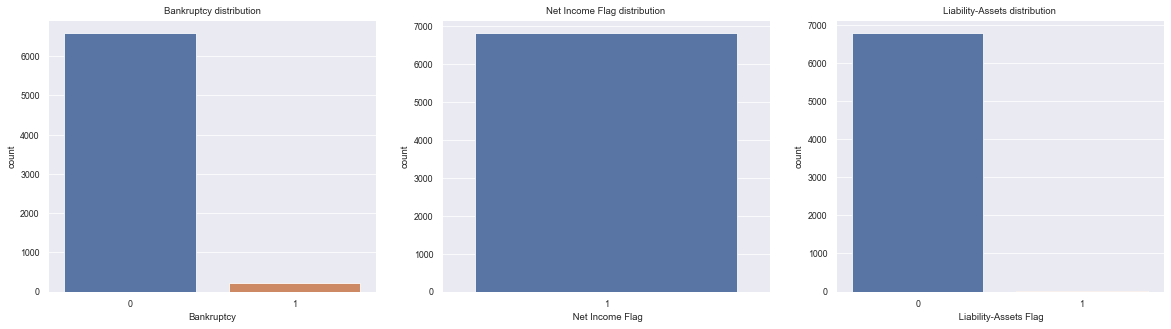

In [26]:
# Checking labels distributions

f, axes = plt.subplots(ncols=3, figsize=(20,5))

#----------------------------------------------
sns.set_theme(context = 'paper')

sns.countplot(base['Bankruptcy'], ax=axes[0])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
axes[0].set_title('Bankruptcy distribution')

#----------------------------------------------
#----------------------------------------------
sns.set_theme(context = 'paper')

sns.countplot(base[' Net Income Flag'], ax=axes[1])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
axes[1].set_title('Net Income Flag distribution')

#----------------------------------------------
#----------------------------------------------
sns.set_theme(context = 'paper')

sns.countplot(base[' Liability-Assets Flag'], ax=axes[2])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
axes[2].set_title('Liability-Assets distribution')

#----------------------------------------------


plt.show()

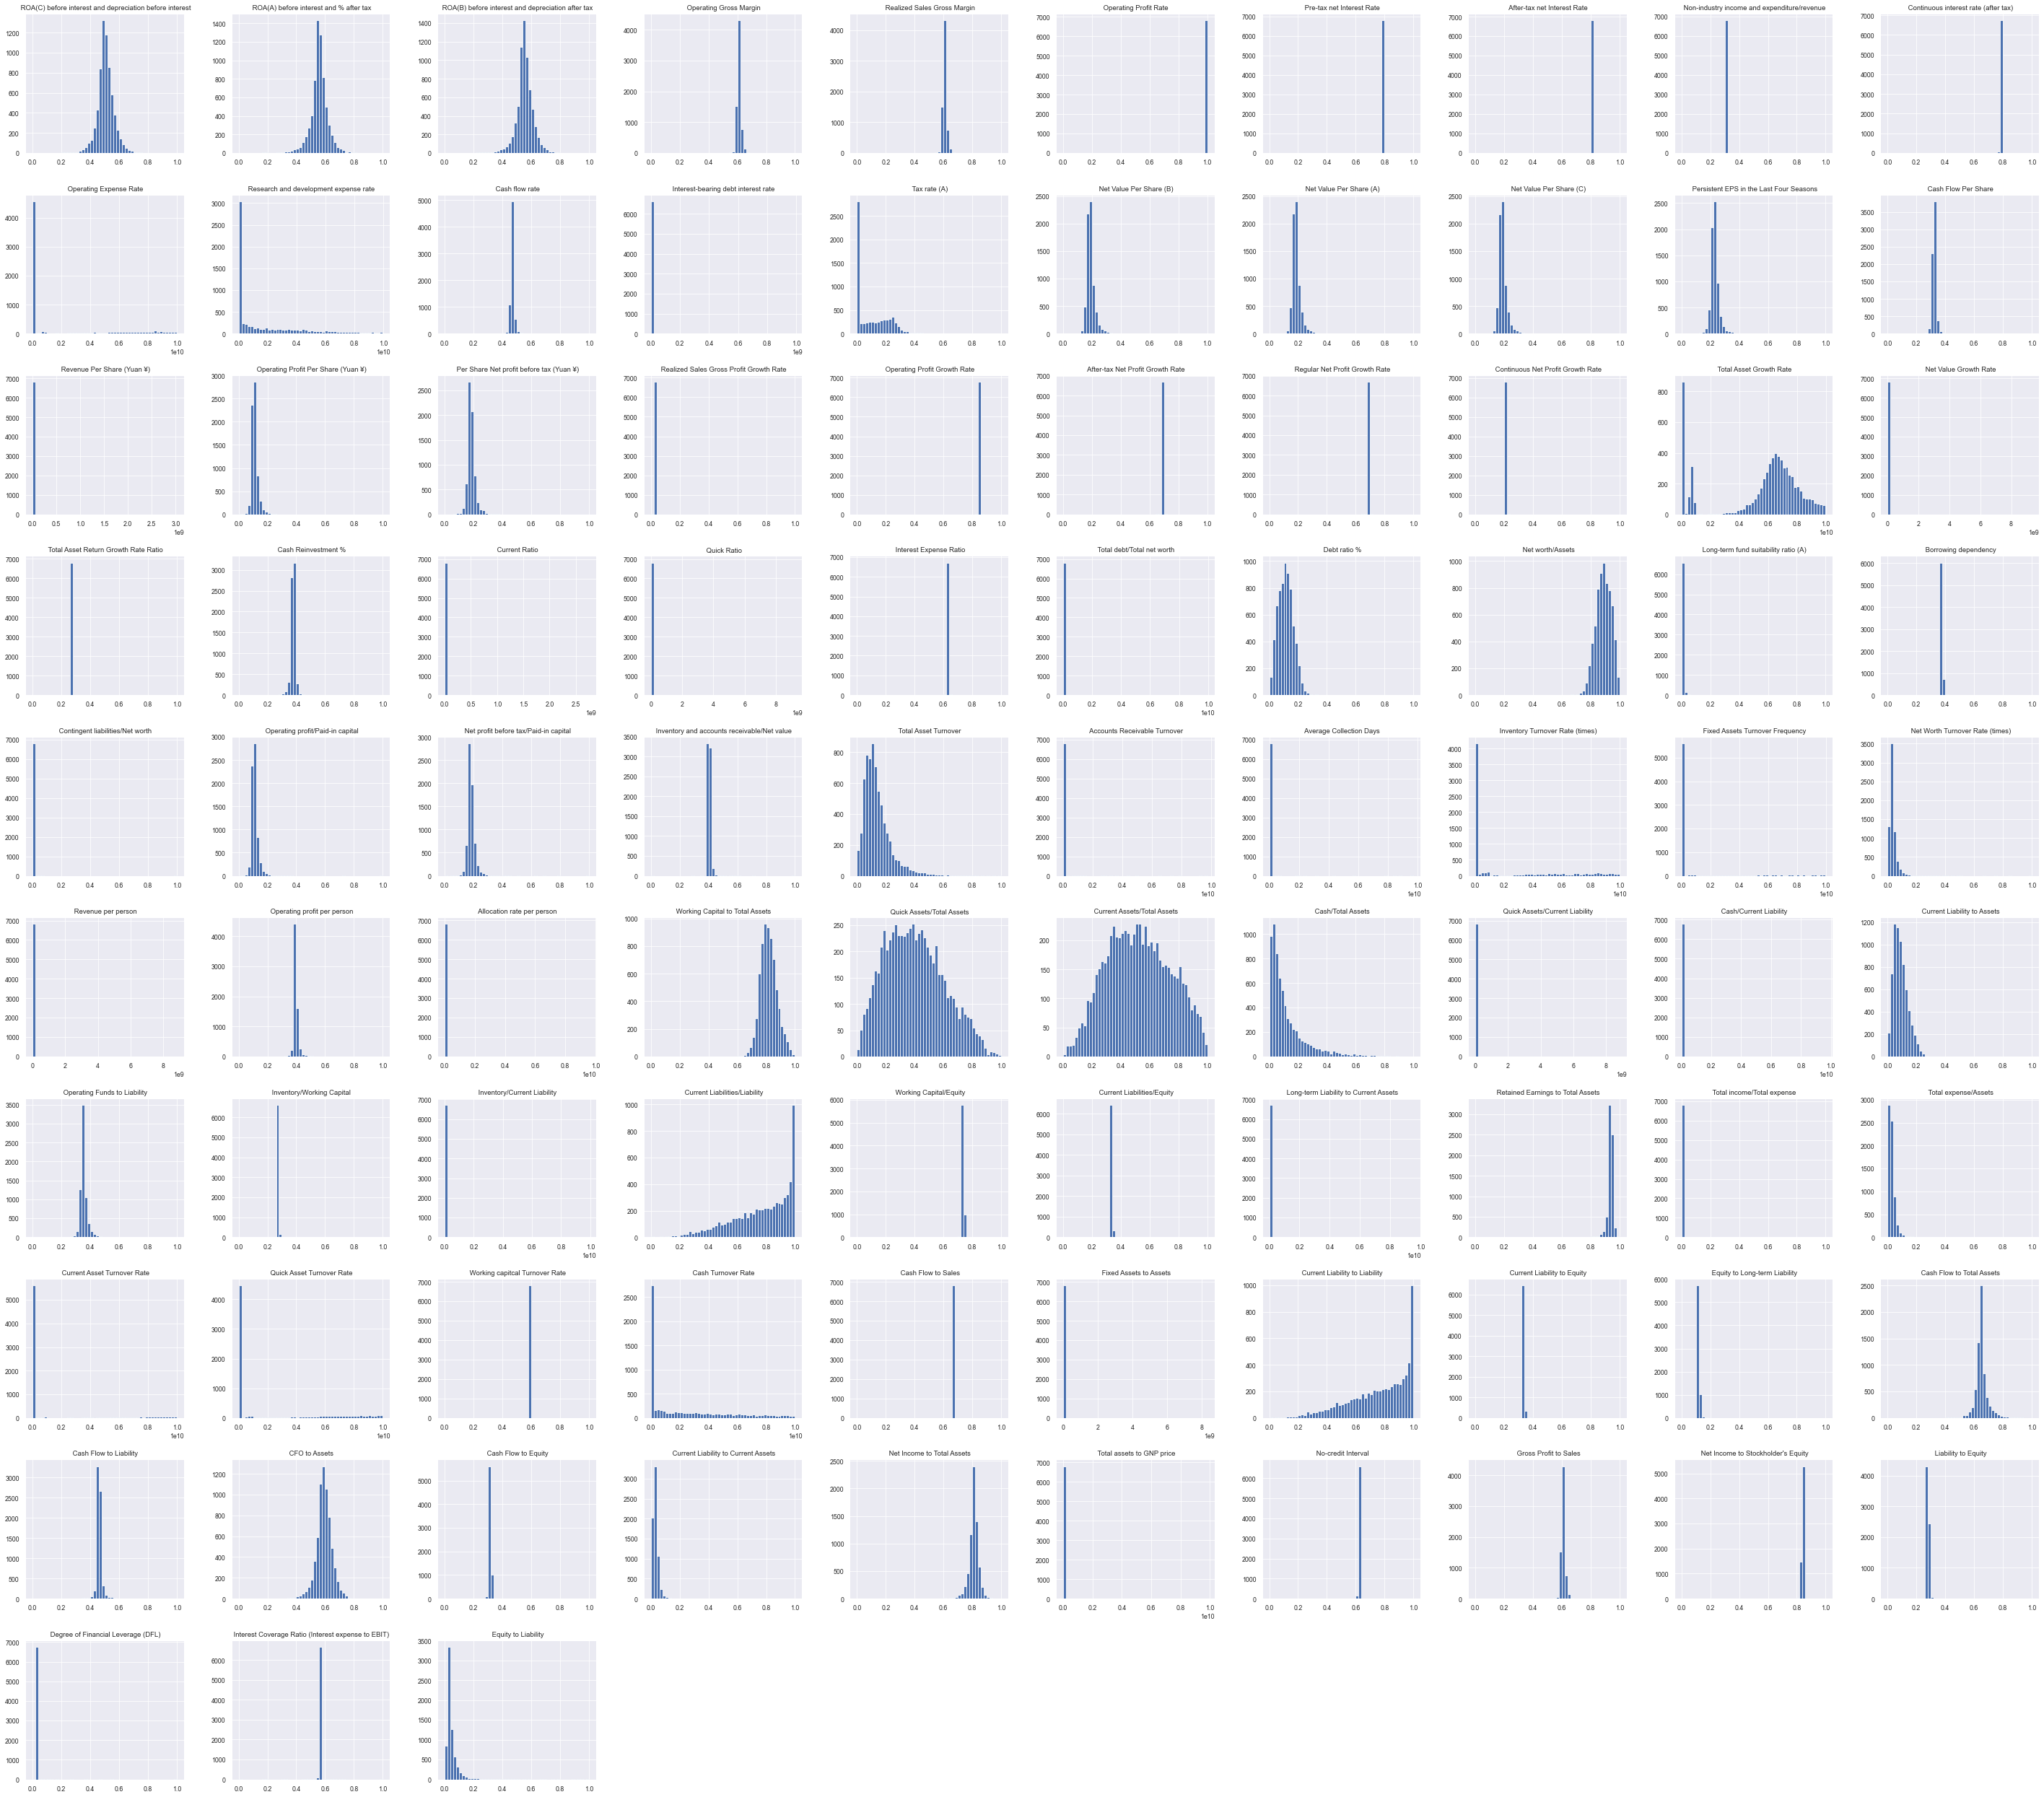

Wall time: 25.3 s


In [27]:
%%time

#On visualise les 93 variables quantitatives (pas de réel intèrêt au vu du nombre de variables)
v_num.hist(figsize = (50,45), bins = 50)
plt.show()

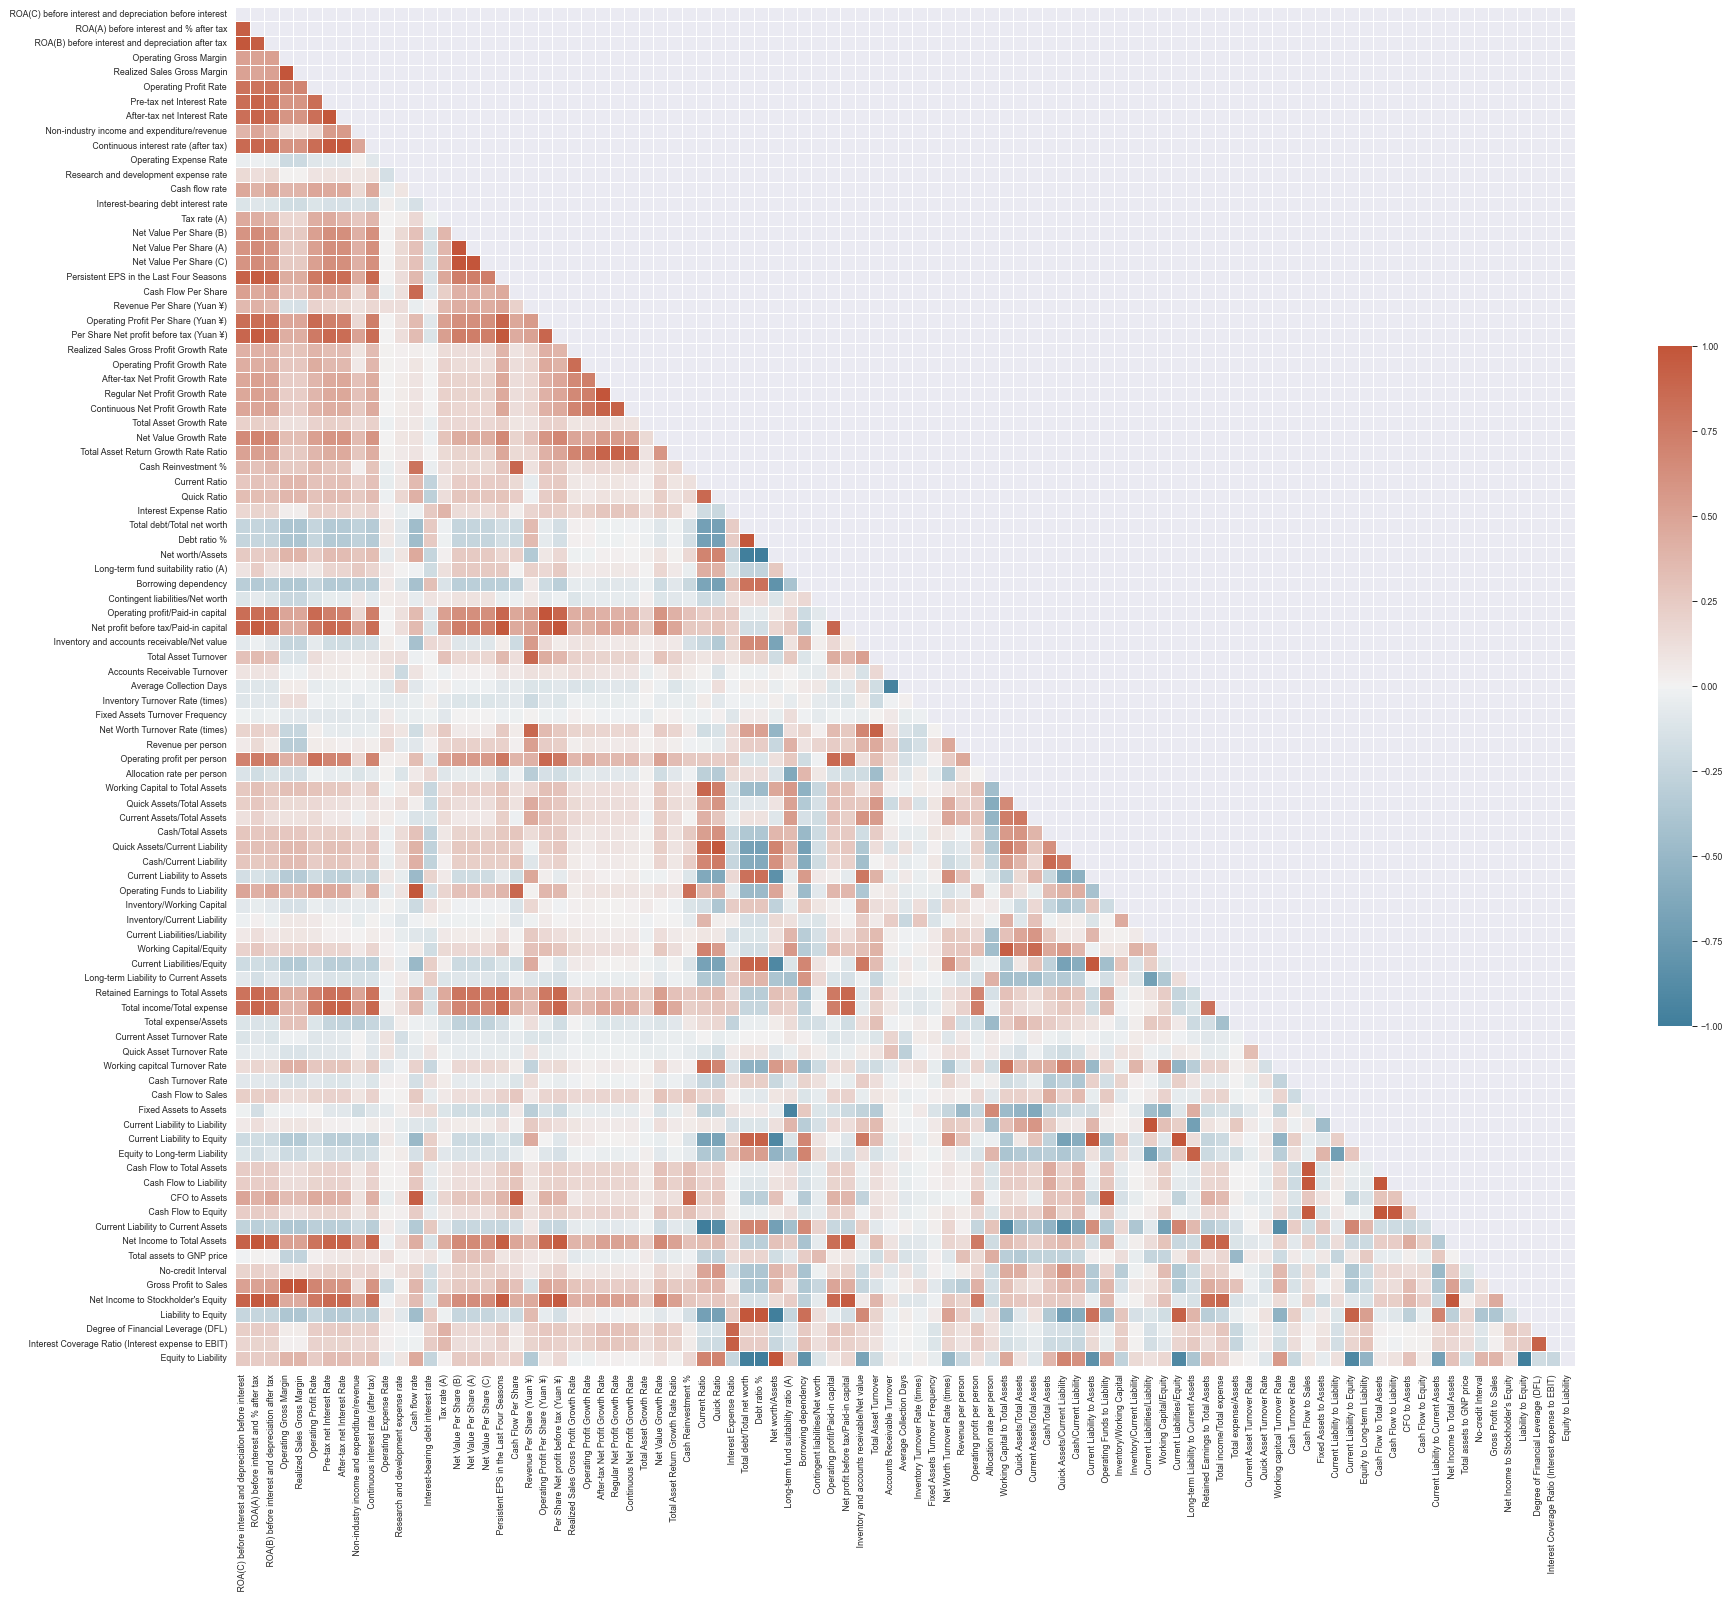

Wall time: 11 s


In [52]:
%%time
# Correlation Heatmap (Spearman)

f, ax = plt.subplots(figsize=(30, 25))

correlation_s = v_num.corr('spearman').round(2)

mask = np.triu(np.ones_like(correlation_s, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation_s, mask = mask, cmap = cmap, vmax = 1, vmin = -1,  center = 0, annot = False,
            square = False, linewidths =.5, cbar_kws={"shrink": .5})
plt.show()

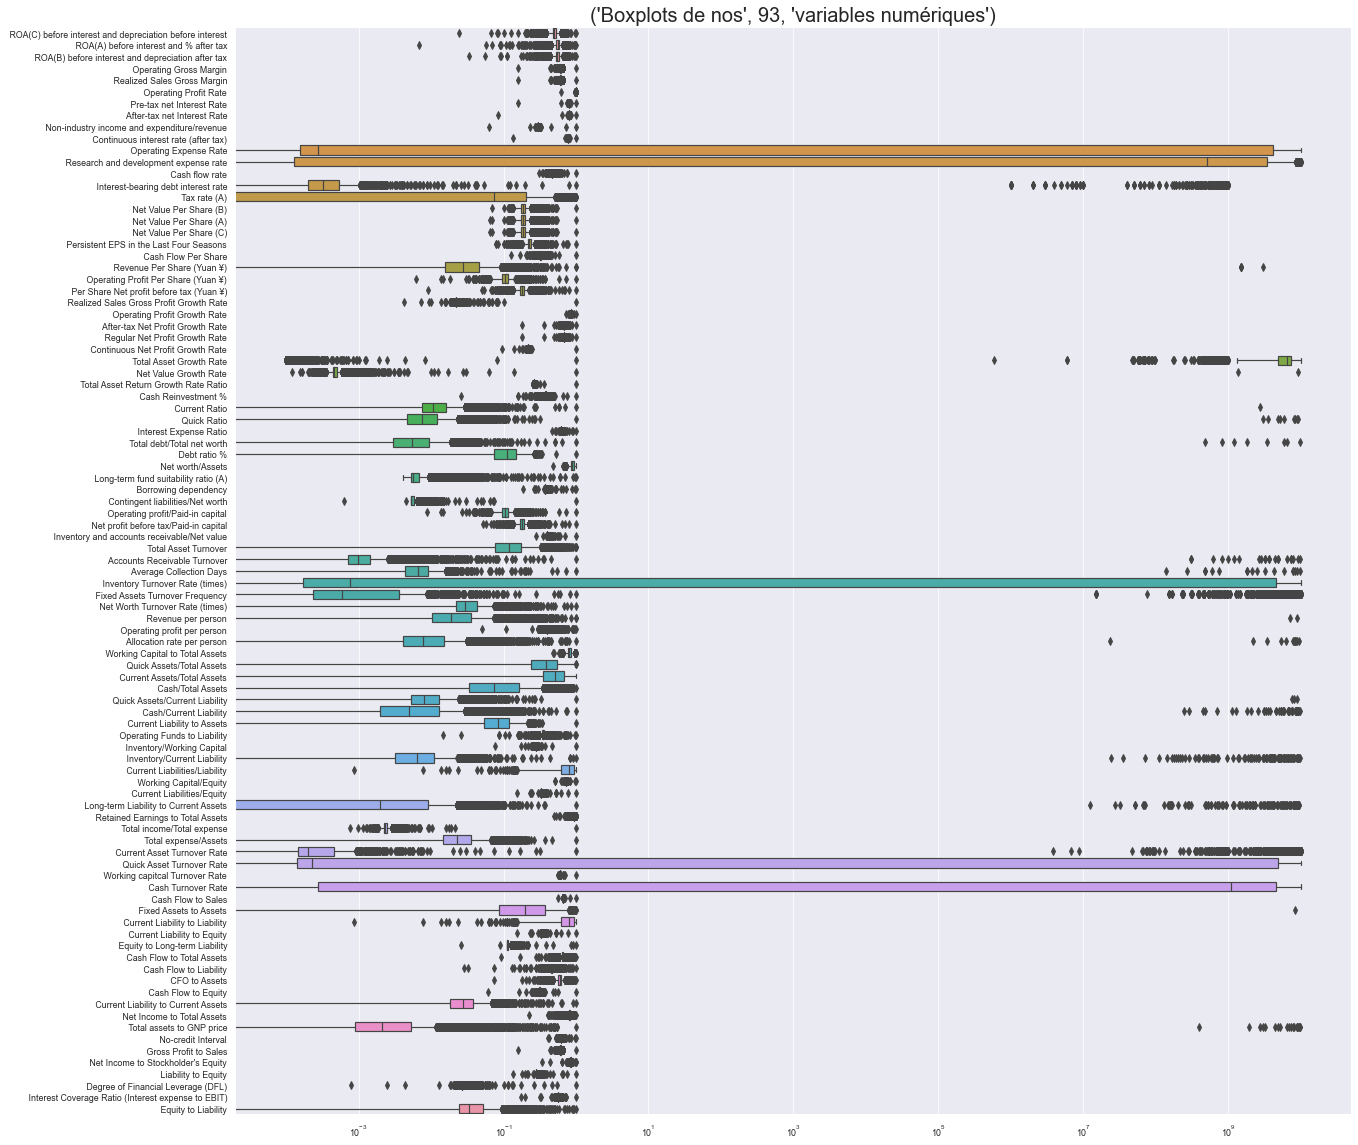

Wall time: 4.32 s


In [69]:
%%time
# Les Boxplots Pour notre base numèrique
plt.figure(figsize = (20,20))

ax =sns.boxplot(data = v_num, orient="h")

ax.set_title( label = ("Boxplots de nos" len(v_num.axes[1]) "variables numériques")
             ,fontsize = 20)
ax.set(xscale="log")

plt.show()

In [ ]:
# Traitements des outliers graçe via l'intervalle interquartille

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile (feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

for x in base:
    base2 = outliers_removal(base[x],str(x),base)
    
#Source : https://www.kaggle.com/code/marto24/bankruptcy-detection?scriptVersionId=56676526&cellId=26

Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
Bankruptcy Lower: 0.0
Bankruptcy Upper: 0.0
Bankruptcy outliers for close to bankruptcy cases: 220
-----------------------------------------------------------------
Quartile 25: 0.476527080388047 | Quartile 75: 0.535562813825379
iqr: 0.05903573343733198
Cut Off: 0.08855360015599797
 ROA(C) before interest and depreciation before interest Lower: 0.38797348023204903
 ROA(C) before interest and depreciation before interest Upper: 0.624116413981377
 ROA(C) before interest and depreciation before interest outliers for close to bankruptcy cases: 391
-----------------------------------------------------------------
Quartile 25: 0.53554295682512 | Quartile 75: 0.58915721761884
iqr: 0.05361426079372
Cut Off: 0.08042139119058
 ROA(A) before interest and % after tax Lower: 0.45512156563454
 ROA(A) before interest and % after tax Upper: 0.66957860880942
 ROA(A) before interest and % after tax outliers for close to bankruptcy cases: 561
----

In [ ]:
base2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6270 entries, 0 to 6817
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankruptcy                                                6270 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6270 non-null   float64
 2    ROA(A) before interest and % after tax                   6270 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6270 non-null   float64
 4    Operating Gross Margin                                   6270 non-null   float64
 5    Realized Sales Gross Margin                              6270 non-null   float64
 6    Operating Profit Rate                                    6270 non-null   float64
 7    Pre-tax net Interest Rate                                6270 non-null   float64
 8    After-tax net Int

In [ ]:
base2.shape, base.shape
diff = len(base.axes[0]) - len(base2.axes[0])

print ("Après le traitement des outliers nous nous retrouvons avec", diff, "observations en moins")

Après le traitement des outliers nous nous retrouvons avec 549 observations en moins


In [ ]:
base.isnull().sum().max()

0

In [ ]:
base.isna().sum(axis=0)

Bankruptcy                                                  0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [ ]:
#Proportion de nos deux évenements "faillite" et "non-faillite" :

no_fail = round(base['Bankruptcy'].value_counts()[0]/len(base) * 100,3)

fail = round(base['Bankruptcy'].value_counts()[1]/len(base) * 100,3)

print('La non faillite représente', no_fail , '% de nos entreprises')
print('La faillite représente', fail , '% de nos entreprises')

if no_fail > fail:
    print("Nous avons un désequilibre en faveur de la non-faillite de nos entreprises")
elif no_fail < fail:
    print("Nous avons un désequilibre en faveur de la faillite de nos entreprises")
elif no_fail == fail:
    print("Nous n'avons pas de désequilibre")

La non faillite représente 96.774 % de nos entreprises
La faillite représente 3.226 % de nos entreprises
Nous avons un désequilibre en faveur de la non-faillite de nos entreprises


In [ ]:
#On centre et on réduit nos données numèriques

#On scinde nos données corrigées des outliers
v_num2 = base2.drop(['Bankruptcy',' Liability-Assets Flag',' Net Income Flag'], axis = 1)
v_bin2 = base2[['Bankruptcy', ' Liability-Assets Flag',' Net Income Flag']]

S_scaler = StandardScaler()

S_scaler.fit_transform(v_num2)

array([[-2.24839945e+00, -2.08772214e+00, -2.43673016e+00, ...,
        -6.15482816e-02, -9.59985211e-02, -1.13537593e+00],
       [-6.81934266e-01, -3.14513655e-01, -6.05766311e-01, ...,
         1.45054741e+01,  3.48550322e-01, -9.00149871e-01],
       [-1.32090862e+00, -9.25115619e-01, -1.33885845e+00, ...,
        -6.43585806e-02, -1.20969109e-01, -1.13508372e+00],
       ...,
       [-1.90478227e-01, -2.94981186e-01, -1.68560760e-01, ...,
        -3.31680185e-02,  5.95505219e-02, -4.05514397e-01],
       [-5.00185184e-01, -3.13664417e-01, -4.82995459e-01, ...,
        -3.65770672e-02,  4.68480466e-02,  5.09302683e-02],
       [ 1.97964957e-02,  2.34829823e-02,  9.85443407e-03, ...,
        -4.79948875e-02, -5.17057578e-03,  3.62299191e-01]])

In [ ]:
#On regroupe le tout dans une base 
base_cr = pd.concat([v_bin2,v_num2], axis=1)
base_cr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6270 entries, 0 to 6817
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankruptcy                                                6270 non-null   int64  
 1    Liability-Assets Flag                                    6270 non-null   int64  
 2    Net Income Flag                                          6270 non-null   int64  
 3    ROA(C) before interest and depreciation before interest  6270 non-null   float64
 4    ROA(A) before interest and % after tax                   6270 non-null   float64
 5    ROA(B) before interest and depreciation after tax        6270 non-null   float64
 6    Operating Gross Margin                                   6270 non-null   float64
 7    Realized Sales Gross Margin                              6270 non-null   float64
 8    Operating Profit 

<AxesSubplot:xlabel='Bankruptcy', ylabel='count'>

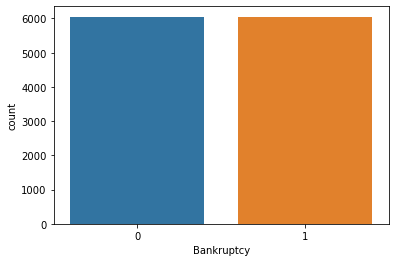

In [ ]:
X=base_cr.drop(labels=['Bankruptcy'], axis=1)
Y=base_cr['Bankruptcy']

oversample = SMOTE()
X,Y=oversample.fit_resample(X,Y)
sns.countplot(x=Y)

<AxesSubplot:xlabel='Bankruptcy', ylabel='count'>

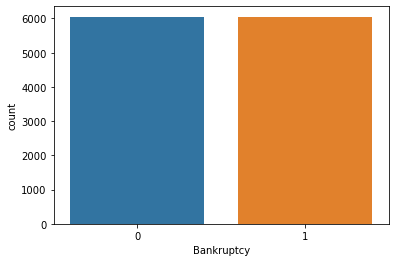

In [ ]:
#Création d'une base équilibrée
base_crb = pd.concat([Y,X], axis=1)

sns.countplot(x=base_crb['Bankruptcy'])

In [ ]:
base_crb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12104 entries, 0 to 12103
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankruptcy                                                12104 non-null  int64  
 1    Liability-Assets Flag                                    12104 non-null  int64  
 2    Net Income Flag                                          12104 non-null  int64  
 3    ROA(C) before interest and depreciation before interest  12104 non-null  float64
 4    ROA(A) before interest and % after tax                   12104 non-null  float64
 5    ROA(B) before interest and depreciation after tax        12104 non-null  float64
 6    Operating Gross Margin                                   12104 non-null  float64
 7    Realized Sales Gross Margin                              12104 non-null  float64
 8    Operating Profi

***

## <center> Features selection process <center>

***

### Méthode 1 : Régression pénalisée : le LASSO (contrainte haute)


In [ ]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=14)

#define model
model = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1)

#fit model
model.fit(X, Y)

#display lambda that produced the lowest test MSE
print(model.alpha_)
#0.01

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linea

0.01


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.1259951029037, tolerance: 0.2723499908206354
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.6158699158073, 

In [ ]:
pipeline = Pipeline([('scaler',StandardScaler()),('model',Lasso())])

search = GridSearchCV(pipeline, {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 10, scoring="neg_mean_squared_error",verbose=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

search.fit(X_train,y_train) ;

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ................model__alpha=0.1;, score=-0.144 total time=   0.0s
[CV 2/10] END ................model__alpha=0.1;, score=-0.145 total time=   0.0s
[CV 3/10] END ................model__alpha=0.1;, score=-0.148 total time=   0.0s
[CV 4/10] END ................model__alpha=0.1;, score=-0.146 total time=   0.0s
[CV 5/10] END ................model__alpha=0.1;, score=-0.151 total time=   0.0s
[CV 6/10] END ................model__alpha=0.1;, score=-0.143 total time=   0.0s
[CV 7/10] END ................model__alpha=0.1;, score=-0.142 total time=   0.0s
[CV 8/10] END ................model__alpha=0.1;, score=-0.143 total time=   0.0s
[CV 9/10] END ................model__alpha=0.1;, score=-0.146 total time=   0.0s
[CV 10/10] END ...............model__alpha=0.1;, score=-0.146 total time=   0.0s
[CV 1/10] END ................model__alpha=0.2;, score=-0.184 total time=   0.0s
[CV 2/10] END ................model__alpha=0.2

In [ ]:
search.best_params_
# {'model__alpha': 0.1}

{'model__alpha': 0.1}

In [72]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [73]:
coefficients

array([-0.        ,  0.        , -0.08242268, -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.04588127, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.12405525, -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.00919389, -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.  

In [74]:
importance = np.abs(coefficients)

features = X.columns

np.array(features)[importance > 0]

#ROA(C) before interest and depreciation before interest', ' Persistent EPS in the Last Four Seasons', ' Debt ratio %', 
#  ' Working Capital to Total Assets', ' Total income/Total expense'
#np.array(features)[importance == 0]

array([' ROA(C) before interest and depreciation before interest',
       ' Persistent EPS in the Last Four Seasons', ' Debt ratio %',
       ' Working Capital to Total Assets', ' Total income/Total expense'],
      dtype=object)

In [69]:
base_lasso = base_crb[['Bankruptcy',' ROA(C) before interest and depreciation before interest',' Persistent EPS in the Last Four Seasons',
                      ' Debt ratio %', ' Working Capital to Total Assets', ' Total income/Total expense']]

#Changer le type de nos variables binaires : de "int64" ==> "bool" (une seule variable, mais les boucles c'est bien)
for col_name in base_lasso.columns:
   if(base_lasso[col_name].dtype == 'int64'): base_lasso[col_name]= base_lasso[col_name].astype('bool')

base_lasso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12104 entries, 0 to 12103
Data columns (total 6 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankruptcy                                                12104 non-null  bool   
 1    ROA(C) before interest and depreciation before interest  12104 non-null  float64
 2    Persistent EPS in the Last Four Seasons                  12104 non-null  float64
 3    Debt ratio %                                             12104 non-null  float64
 4    Working Capital to Total Assets                          12104 non-null  float64
 5    Total income/Total expense                               12104 non-null  float64
dtypes: bool(1), float64(5)
memory usage: 484.8 KB


C:\Users\admin\AppData\Local\Temp/ipykernel_16012/2179156694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(base_lasso[col_name].dtype == 'int64'): base_lasso[col_name]= base_lasso[col_name].astype('bool')


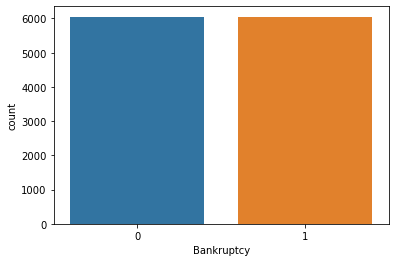

In [83]:
X_lasso = base_lasso.drop(["Bankruptcy"], axis = 1)
Y_lasso = base_lasso["Bankruptcy"]

sns.countplot(x=Y)

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, Y_lasso, test_size=0.33, random_state=42)

### Méthode 2 : Régression pénalisée : l'Elastic Net (contrainte moyenne)

In [98]:
selector = SelectFromModel(SGDClassifier(penalty='elasticnet',random_state=1042), threshold='mean')
selector.fit_transform(X,Y)
selector.get_support()

#On affiche les variables retenues
np.array(X.columns)[selector.get_support()]

#array([' Interest-bearing debt interest rate',
#       ' Revenue Per Share (Yuan ¥)', ' Net Value Growth Rate',
#       ' Current Ratio', ' Accounts Receivable Turnover',
#       ' Average Collection Days', ' Revenue per person',
#       ' Allocation rate per person', ' Quick Assets/Current Liability',
#       ' Fixed Assets to Assets'])

array([' Interest-bearing debt interest rate',
       ' Revenue Per Share (Yuan ¥)', ' Net Value Growth Rate',
       ' Current Ratio', ' Accounts Receivable Turnover',
       ' Average Collection Days', ' Revenue per person',
       ' Allocation rate per person', ' Quick Assets/Current Liability',
       ' Fixed Assets to Assets', ' Total assets to GNP price'],
      dtype=object)

In [68]:
base_elasticnet = base_crb[['Bankruptcy', ' Interest-bearing debt interest rate',
       ' Revenue Per Share (Yuan ¥)', ' Net Value Growth Rate',
       ' Current Ratio', ' Accounts Receivable Turnover',
       ' Average Collection Days', ' Revenue per person',
       ' Allocation rate per person', ' Quick Assets/Current Liability',
       ' Fixed Assets to Assets']]

for col_name in base_elasticnet.columns:
   if(base_elasticnet[col_name].dtype == 'int64'): base_elasticnet[col_name]= base_elasticnet[col_name].astype('bool')

base_elasticnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12104 entries, 0 to 12103
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Bankruptcy                            12104 non-null  bool   
 1    Interest-bearing debt interest rate  12104 non-null  float64
 2    Revenue Per Share (Yuan ¥)           12104 non-null  float64
 3    Net Value Growth Rate                12104 non-null  float64
 4    Current Ratio                        12104 non-null  float64
 5    Accounts Receivable Turnover         12104 non-null  float64
 6    Average Collection Days              12104 non-null  float64
 7    Revenue per person                   12104 non-null  float64
 8    Allocation rate per person           12104 non-null  float64
 9    Quick Assets/Current Liability       12104 non-null  float64
 10   Fixed Assets to Assets               12104 non-null  float64
dtypes: bool(1), flo

C:\Users\admin\AppData\Local\Temp/ipykernel_16012/2903849533.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(base_elasticnet[col_name].dtype == 'int64'): base_elasticnet[col_name]= base_elasticnet[col_name].astype('bool')


### Méthode 3 : "Recursive Feature Elimination, Cross-Validated" (RFECV) (pénalité Elastic Net)

In [103]:
from sklearn.feature_selection import RFECV

selector3 = RFECV(SGDClassifier(penalty ='elasticnet',random_state = 2042), step = 10, cv = 10)
selector3.fit_transform(X,Y)
selector3.get_support()

#On affiche les vriable retenues
np.array(X.columns)[selector3.get_support()]

#array([' Net Income Flag', ' Operating Profit Rate',
#       ' Operating Expense Rate',
#       ' Research and development expense rate',
#       ' Interest-bearing debt interest rate',
#       ' Revenue Per Share (Yuan ¥)', ' Total Asset Growth Rate',
#       ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio',
#       ' Accounts Receivable Turnover', ' Average Collection Days',
#       ' Inventory Turnover Rate (times)',
#       ' Fixed Assets Turnover Frequency', ' Revenue per person',
#       ' Allocation rate per person', ' Quick Assets/Current Liability',
#       ' Cash/Current Liability', ' Inventory/Current Liability',
#       ' Long-term Liability to Current Assets',
#       ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate',
#       ' Cash Turnover Rate', ' Fixed Assets to Assets',
#       ' Total assets to GNP price']

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([' Net Income Flag', ' Operating Profit Rate',
       ' Operating Expense Rate',
       ' Research and development expense rate',
       ' Interest-bearing debt interest rate',
       ' Revenue Per Share (Yuan ¥)', ' Total Asset Growth Rate',
       ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio',
       ' Accounts Receivable Turnover', ' Average Collection Days',
       ' Inventory Turnover Rate (times)',
       ' Fixed Assets Turnover Frequency', ' Revenue per person',
       ' Allocation rate per person', ' Quick Assets/Current Liability',
       ' Cash/Current Liability', ' Inventory/Current Liability',
       ' Long-term Liability to Current Assets',
       ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate',
       ' Cash Turnover Rate', ' Fixed Assets to Assets',
       ' Total assets to GNP price'], dtype=object)

In [159]:
base_RFECV = base_crb[['Bankruptcy',' Net Income Flag', ' Operating Profit Rate',' Operating Expense Rate',
       ' Research and development expense rate', ' Interest-bearing debt interest rate',
       ' Revenue Per Share (Yuan ¥)', ' Total Asset Growth Rate',
       ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio',
       ' Accounts Receivable Turnover', ' Average Collection Days',
       ' Inventory Turnover Rate (times)',
       ' Fixed Assets Turnover Frequency', ' Revenue per person',
       ' Allocation rate per person', ' Quick Assets/Current Liability',
       ' Cash/Current Liability', ' Inventory/Current Liability',
       ' Long-term Liability to Current Assets',
       ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate',
       ' Cash Turnover Rate', ' Fixed Assets to Assets',
       ' Total assets to GNP price']]

for col_name in base_RFECV.columns:
   if(base_RFECV[col_name].dtype == 'int64'): base_RFECV[col_name]= base_RFECV[col_name].astype('bool')

base_RFECV[' Research and development expense rate'] = base_RFECV[' Research and development expense rate'].astype('int32')

base_RFECV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12104 entries, 0 to 12103
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Bankruptcy                              12104 non-null  bool   
 1    Net Income Flag                        12104 non-null  bool   
 2    Operating Profit Rate                  12104 non-null  float64
 3    Operating Expense Rate                 12104 non-null  float64
 4    Research and development expense rate  12104 non-null  int32  
 5    Interest-bearing debt interest rate    12104 non-null  float64
 6    Revenue Per Share (Yuan ¥)             12104 non-null  float64
 7    Total Asset Growth Rate                12104 non-null  float64
 8    Net Value Growth Rate                  12104 non-null  float64
 9    Current Ratio                          12104 non-null  float64
 10   Quick Ratio                            12104 non-null  fl

C:\Users\admin\AppData\Local\Temp/ipykernel_16012/236897100.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(base_RFECV[col_name].dtype == 'int64'): base_RFECV[col_name]= base_RFECV[col_name].astype('bool')
C:\Users\admin\AppData\Local\Temp/ipykernel_16012/236897100.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_RFECV[' Research and development expense rate'] = base_RFECV[' Research and development expense rate'].astype('int32')


***

## <center> Exploration univariée de notre phénomène <center>

***

In [71]:
base_lasso['Bankruptcy'].describe()

count     12104
unique        2
top        True
freq       6052
Name: Bankruptcy, dtype: object

In [72]:
base_elasticnet['Bankruptcy'].describe()

count     12104
unique        2
top        True
freq       6052
Name: Bankruptcy, dtype: object

In [73]:
base_RFECV['Bankruptcy'].describe()

count     12104
unique        2
top        True
freq       6052
Name: Bankruptcy, dtype: object

In [194]:
base_lasso.shape, base_elasticnet.shape, base_RFECV.shape

#profile_RFECV = ProfileReport(base_RFECV, title="Profiling Report")
#profile_RFECV

#Ne marche pas, nous ne savons pas pourqoi

((12104, 26), (12104, 11), (12104, 6))

Le "ProfileReport" ne marche que pour la base Lasso. Nous n'avons pas réussi à decoder la raison de l'erreur concernant les autres bases

## <center> Exploration bivariée de notre phénomène <center>

### T test pour les couples "qualitatif-quantitatif"

Test de student, ou T-test, sur la base issue de la sélection via lasso.<br> 
- H0 : Il n'existe pas de différence significative entre les deux variables
- H1 : Il existe une différence significative entre les deux variables.

In [182]:
base_lasso_2 = base_lasso.drop(['Bankruptcy'], axis = 1)

for  a in base_lasso_2.columns:
        
        stat, p = ttest_ind(Y,base_lasso_2[a])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Pour les variable',Y.name,'et',base_lasso_2[a].name,'les distributions sont similaires')
            print('La variable', base_lasso_2[a].name, 'a été supprimée')
            del base_lasso_2[a]
        else:
            print('Pour les variable',Y.name,'et',base_lasso_2[a].name,'les distributions sont différentes')

base_elasticnet_cleaned = pd.concat([base_elasticnet[['Bankruptcy']], base_lasso_2], axis=1)

stat=7.951, p=0.000
Pour les variable Bankruptcy et  ROA(C) before interest and depreciation before interest les distributions sont différentes
stat=63.849, p=0.000
Pour les variable Bankruptcy et  Persistent EPS in the Last Four Seasons les distributions sont différentes
stat=75.717, p=0.000
Pour les variable Bankruptcy et  Debt ratio % les distributions sont différentes
stat=-61.337, p=0.000
Pour les variable Bankruptcy et  Working Capital to Total Assets les distributions sont différentes
stat=109.521, p=0.000
Pour les variable Bankruptcy et  Total income/Total expense les distributions sont différentes


> Suite aux résultats ci-dessus, nous n'avons pas besoin de retirer des variables de la base Lasso

In [171]:
base_elasticnet_2 = base_elasticnet.drop(['Bankruptcy'], axis = 1)

for  a in base_elasticnet_2.columns:
        
        stat, p = ttest_ind(Y,base_elasticnet_2[a])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Pour les vaiable',Y.name,'et',base_elasticnet_2[a].name,'les distributions sont similaires')
            print('La variable', base_elasticnet_2[a].name, 'a été supprimée')
            del base_elasticnet_2[a]
        else:
            print('Pour les variable',Y.name,'et',base_elasticnet_2[a].name,'les distributions sont différentes')

base_elasticnet_cleaned = pd.concat([base_elasticnet[['Bankruptcy']], base_elasticnet_2], axis=1)

stat=-13.093, p=0.000
Pour les variable Bankruptcy et  Interest-bearing debt interest rate les distributions sont différentes
stat=-1.732, p=0.083
Pour les vaiable Bankruptcy et  Revenue Per Share (Yuan ¥) les distributions sont similaires
La variable  Revenue Per Share (Yuan ¥) a été supprimée
stat=-4.846, p=0.000
Pour les variable Bankruptcy et  Net Value Growth Rate les distributions sont différentes
stat=-1.000, p=0.317
Pour les vaiable Bankruptcy et  Current Ratio les distributions sont similaires
La variable  Current Ratio a été supprimée
stat=-4.407, p=0.000
Pour les variable Bankruptcy et  Accounts Receivable Turnover les distributions sont différentes
stat=-3.124, p=0.002
Pour les variable Bankruptcy et  Average Collection Days les distributions sont différentes
stat=-4.585, p=0.000
Pour les variable Bankruptcy et  Revenue per person les distributions sont différentes
stat=-4.562, p=0.000
Pour les variable Bankruptcy et  Allocation rate per person les distributions sont différ

> Suite aux résultats ci-dessus, Pour la base Elastic-Net, nous avons retirer les variables dont la distribution est similaire

In [123]:
base_elasticnet_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12104 entries, 0 to 12103
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Bankruptcy                            12104 non-null  bool   
 1    Interest-bearing debt interest rate  12104 non-null  float64
 2    Net Value Growth Rate                12104 non-null  float64
 3    Accounts Receivable Turnover         12104 non-null  float64
 4    Average Collection Days              12104 non-null  float64
 5    Revenue per person                   12104 non-null  float64
 6    Allocation rate per person           12104 non-null  float64
 7    Fixed Assets to Assets               12104 non-null  float64
dtypes: bool(1), float64(7)
memory usage: 673.9 KB


In [163]:
base_RFECV_2 = base_RFECV.drop(['Bankruptcy', ' Net Income Flag'], axis = 1)
base_RFECV_cleaned = base_RFECV.copy(deep=True)

for a in base_RFECV_2.columns: 
    stat, p = ttest_ind(Y, base_RFECV_2[a])
    print('stat=%.3f, p=%.3f' % (stat, p))
        
    if p > 0.05:
        print('Pour les variable',Y.name,'et',base_RFECV_2[a].name,'les distributions sont similaires')
        print('La variable', base_RFECV_2[a].name, 'a été supprimée')
        del base_RFECV_2[a]
        
    else:
        print('Pour les variable',Y.name,'et',base_RFECV_2[a].name,'les distributions sont différentes')
        
base_RFECV_cleaned = pd.concat([base_RFECV[['Bankruptcy', ' Net Income Flag']],base_RFECV_2], axis=1)

stat=-109.716, p=0.000
Pour les variable Bankruptcy et  Operating Profit Rate les distributions sont différentes
stat=-66.710, p=0.000
Pour les variable Bankruptcy et  Operating Expense Rate les distributions sont différentes
stat=31.159, p=0.000
Pour les variable Bankruptcy et  Research and development expense rate les distributions sont différentes
stat=-13.093, p=0.000
Pour les variable Bankruptcy et  Interest-bearing debt interest rate les distributions sont différentes
stat=-1.732, p=0.083
Pour les variable Bankruptcy et  Revenue Per Share (Yuan ¥) les distributions sont similaires
La variable  Revenue Per Share (Yuan ¥) a été supprimée
stat=-226.998, p=0.000
Pour les variable Bankruptcy et  Total Asset Growth Rate les distributions sont différentes
stat=-4.846, p=0.000
Pour les variable Bankruptcy et  Net Value Growth Rate les distributions sont différentes
stat=-1.000, p=0.317
Pour les variable Bankruptcy et  Current Ratio les distributions sont similaires
La variable  Current R

> Suite aux résultats ci-dessus, Pour la base RFECV, nous avons retirer les variables dont la distribution est similaire

### Test de Chi² pour les couples "qualitatif-quantitatif"

Test de Chi² pour notre couple quali/quali (base : RFECV_cleaned)
- H0 : The variables have no association or correlation amongst them.
- H1 : The variables are associated with each other, there is a correlation between the variables.

In [184]:
# Création de la table de contingence
data_crosstab = pd.crosstab(base_RFECV_cleaned['Bankruptcy'], base_RFECV_cleaned[' Net Income Flag'], margins=True, margins_name="Total")

# Definition du seuil de confiance à 5%
alpha = 0.05

# Estimation du test de Chi²

chi_square = 0

rows = base_RFECV_cleaned['Bankruptcy'].unique()

columns = base_RFECV_cleaned[' Net Income Flag'].unique()

for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)


base_RFECV_cleaned = base_RFECV_cleaned.drop([' Net Income Flag'], axis = 1)
#source : https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.0  and p value is: nan
Failed to reject the null hypothesis.


Il semblerait que le fait que notre variable "Net Income Flag" soit constituée uniquement de 1 biaise le test.
> Nous décidons de la retirer pour la suite de notre analyse.

## <c> Exploration multivariée de notre phénomène <c>